# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79d317a0e3d0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 15.435 seconds


### Make predictions on the entire test dataset with the model

In [11]:
# Function to make prediction
# Import all neccesary library
import torch
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
# 1. Take in train model, a list of classname, a filepath to the target, a image size, a transform and a target device
def make_prediction(model: torch.nn.Module,
                    classnames: List[str],
                    file_path: str,
                    image_size: Tuple[int, int] = (224, 224), # default values
                    transforms: torchvision.transforms = None,
                    device: torch.device = device):
  # 2.Open an image
  img = Image.open(file_path)
  # 3. Creating a transforms for the images( can use manual or auto)
  if transforms is not None:
    image_transform = transforms
  else:
    image_transform = model_0.transforms()
  # 4. Make sure the model on the target device
  model.to(device)
  # 5. Turn on eval and inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform and add an extra dimension to image
    transformed_image = image_transform(img).unsqueeze(dim=0)
    # 7. Make a prediction on the img by passing it to the model target device
    target_image_pred = model(transformed_image.to(device))
  # 8. Convert logits -> preds probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # 9. Convert pred probs -> pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot the image with matplotlib
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {classnames[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

  # Concatenate list of prediction into a tensor
  target_image_pred_probs_list = target_image_pred_probs.tolist()[0]
  target_image_pred_label_list = target_image_pred_label.tolist()


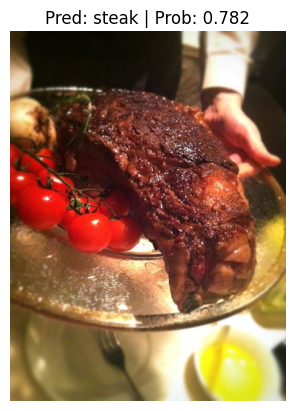

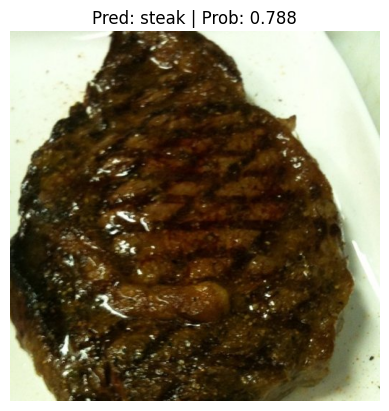

In [24]:
# Get random image from the test set and predict
import random
num_images = 2
num_images_path = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(num_images_path, k=num_images)

# Make prediction
for image_path in random_image_path:
  make_prediction(model=model_0,
                  classnames=class_names,
                  file_path=image_path,
                  image_size=(224, 224),
                  transforms=simple_transform,
                  device=device)

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [13]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxte nd version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
mlxte nd version: 0.23.4


In [14]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [15]:
# Making a confusion matrix with the test preds and truth labels

# To create a confusion matrix, we need to get the model's prediction for the ENTIRE datasets and compare them to the true labels

# Creating model's predictions for the entire datasets
from tqdm.auto import tqdm

# 1. Make prediction with trained models
y_preds = []
y_true = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        # Send the data to the target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logits = model_0(X)
        # Turn  logits -> preds probs -> pred labels
        y_pred_labels = torch.softmax(y_logits, dim=1).argmax(dim=1)
        # Put prediction on CPU for evaluation and append to list
        y_preds.append(y_pred_labels.cpu())
        y_true.append(y.cpu()) # Append true labels to list
# Concatenate list of predictions into tensor
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true)

print(f"Number of test predictions: {len(y_pred_tensor)}")
print(f"Number of true labels: {len(y_true_tensor)}")

  0%|          | 0/3 [00:00<?, ?it/s]

Number of test predictions: 75
Number of true labels: 75


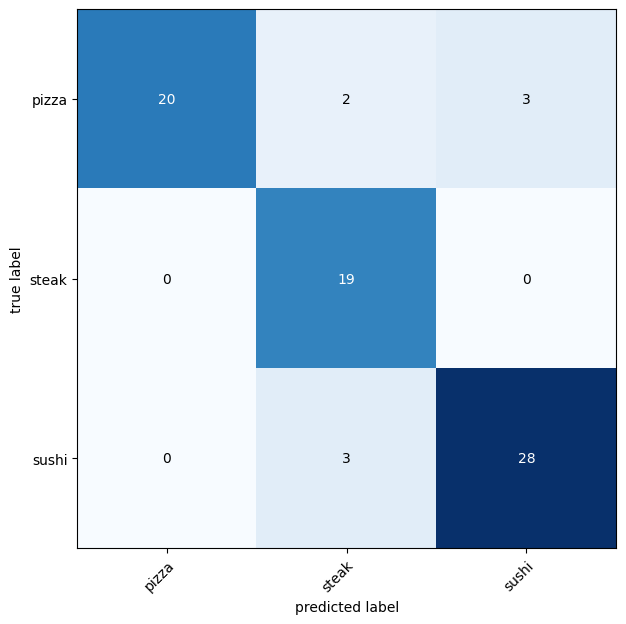

In [16]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_true_tensor)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)
plt.show()

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [17]:
# 1. Setup the test data to take all the data
test_data_path = list(Path(test_dir).glob("*/*.jpg"))
test_label = [path.parent.stem for path in test_data_path]

In [18]:
# 2. Make prediction a get the model reuslt
# Import all the nesseary library
import torch
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
# Create a function to return a list of dictionary with sample, lablel, prediction and preb prob
def pred_and_plot_image(test_path, model, transform, class_names,device):
  # Get an empty string
  test_pred_list = []
  for path in test_path:
    # Create an empty dict to store for each sample
    pred_dict = {}

    # Get sample bathces
    pred_dict["image_path"] = path

    # Get label/class name
    class_name = path.parent.stem
    pred_dict["class_name"] = path.parent.stem

    # Get prediction and prediction probabilities
    img = Image.open(path)
    transformedimage = transform(img).unsqueeze(dim=0)
    model.to(device)
    model.eval()
    with torch.inference_mode():
      pred_logits = model(transformedimage.to(device))
      pred_probs = torch.softmax(pred_logits, dim=1)
      pred_label = torch.argmax(pred_probs, dim=1)
      pred_dict["pred_prob"] = pred_probs.max()
      pred_dict["pred_label"] = class_names[pred_label]
    # Doest the pred match the true label
    pred_dict["correct"] = pred_dict["class_name"] == pred_dict["pred_label"]

    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)


  return test_pred_list

test = pred_and_plot_image(test_data_path, model_0, simple_transform, class_names,device)
test[:5]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
  'class_name': 'sushi',
  'pred_prob': tensor(0.6601, device='cuda:0'),
  'pred_label': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2715127.jpg'),
  'class_name': 'sushi',
  'pred_prob': tensor(0.4312, device='cuda:0'),
  'pred_label': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
  'class_name': 'sushi',
  'pred_prob': tensor(0.4139, device='cuda:0'),
  'pred_label': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
  'class_name': 'sushi',
  'pred_prob': tensor(0.6240, device='cuda:0'),
  'pred_label': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/719108.jpg'),
  'class_name': 'sushi',
  'pred_prob': tensor(0.5397, device='cuda:0'),
  'pred_label': 'sushi',
  'correct': True}]

In [19]:
# Turn the test into DF
import pandas as pd
test_df = pd.DataFrame(test)
testdf = test_df.sort_values(by="correct", ascending=False)
test_df.head()

,image_path,class_name,pred_prob,pred_label,correct
0,data/pizza_steak_sushi/test/sushi/2741434.jpg,sushi,"tensor(0.6601, device='cuda:0')",sushi,True
1,data/pizza_steak_sushi/test/sushi/2715127.jpg,sushi,"tensor(0.4312, device='cuda:0')",sushi,True
2,data/pizza_steak_sushi/test/sushi/479711.jpg,sushi,"tensor(0.4139, device='cuda:0')",sushi,True
3,data/pizza_steak_sushi/test/sushi/499605.jpg,sushi,"tensor(0.6240, device='cuda:0')",sushi,True
4,data/pizza_steak_sushi/test/sushi/719108.jpg,sushi,"tensor(0.5397, device='cuda:0')",sushi,True


In [20]:
# Plot the 5 most wrong with the picture along with it
import torchvision
import matplotlib.pyplot as plt

for index, row in test_df.iterrows():
  image_path = row.iloc[0]
  true_label = row.iloc[1]
  pred_label = row.iloc[3]
  pred_prob = row.iloc[2]
  correct = row.iloc[4]

  # PLot the image
  img = torchvision.io.read_image(str(image_path))
  plt.figure()
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"True: {true_label} | Pred: {pred_label} | Prob: {pred_prob.item():.3f} | Correct: {correct}")
  plt.axis(False)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [26]:
import requests
custom_image_path = Path("custom_image/")
if custom_image_path.is_dir():
    print(f"{custom_image_path} directory exists.")
else:
    print(f"Did not find {custom_image_path} directory, creating one...")
    custom_image_path.mkdir(parents=True, exist_ok=True)
    # Download custome image
    with open(custom_image_path / "pizza.avif", "wb") as f:
        request = requests.get("https://plus.unsplash.com/premium_photo-1673439305009-821f62df6d31?q=80&w=687&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
        print("Downloading pizza custom image...")
    with open(custom_image_path / "not_pizza.avif", "wb") as f:
        request = requests.get("https://images.unsplash.com/photo-1750272001535-524d6a246947?q=80&w=685&auto=format&fit=crop&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
        print("Downloading not pizza custom image...")


Did not find custom_image directory, creating one...


In [31]:
# # Make prediction on custome image


# make_prediction(model=model_0,
#                 classnames=class_names,
#                 file_path=custom_image_path / "pizza.avif",
#                 image_size=(224, 224),
#                 transforms=simple_transform,
#                 device=device)
# make_prediction(model=model_0,
#                 classnames=class_names,
#                 file_path=custom_image_path / "not_pizza.avif",
#                 image_size=(224, 224),
#                 transforms=simple_transform,
#                 device=device)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [43]:
# TODO: Recreate a new model
# This model is a pre-train model using efficientnet_b0

# Setup the model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Print out the summary of the using torchinfo
summary(model_1,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [44]:
# Freeze all base layers in the "features " section of the model
for param in model_1.features.parameters():
    param.requires_grad = False

model_1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [45]:
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=len(class_names), # Change out_features to the number of classes
                    bias=True)
).to(device)

summary(model_1,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [50]:
# TODO: Train the model for 10 epochs
loss_fn = nn.CrossEntropyLoss() # Change loss function to CrossEntropyLoss
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)
# ENd the timer
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0776 | train_acc: 0.4023 | test_loss: 0.8606 | test_acc: 0.7131
Epoch: 2 | train_loss: 0.8621 | train_acc: 0.7148 | test_loss: 0.7770 | test_acc: 0.8352
Epoch: 3 | train_loss: 0.7566 | train_acc: 0.8086 | test_loss: 0.7251 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.7078 | train_acc: 0.7500 | test_loss: 0.6400 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6415 | train_acc: 0.7891 | test_loss: 0.6257 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5770 | train_acc: 0.7930 | test_loss: 0.5526 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.5065 | train_acc: 0.9141 | test_loss: 0.5271 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.5370 | train_acc: 0.7812 | test_loss: 0.5276 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.5593 | train_acc: 0.8086 | test_loss: 0.4896 | test_acc: 0.9593
Epoch: 10 | train_loss: 0.4999 | train_acc: 0.8047 | test_loss: 0.4143 | test_acc: 0.8759
[INFO] Total training time: 19.197 seconds


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [51]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [52]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [53]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79d27646c210>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [59]:
# TODO
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
models_20 = torchvision.models.efficientnet_b0(weights=weights).to(device)


### Train a model with 20% of the data

In [72]:
# TODO

# Freezing the base model and change the output to suit the needdsd
for params in models_20.features.parameters():
  params.requires_grad = False

models_20.classifer = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=len(class_names),
                    bias=True)
).to(device)


In [76]:
# Train the model

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names
output_shape = len(class_names)

summary(models_20,
                     input_size=(32, 3, 224, 224),
                     col_names=["input_size", "output_size", "num_params", "trainable"],
                     col_width=20,
                     row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           3,843                Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [77]:
# Train the model
# train and loss funtion
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(models_20.parameters(), lr=0.001)

# start the timerr
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=models_20,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)
# endd timer
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.5318 | train_acc: 0.0667 | test_loss: 3.3876 | test_acc: 0.1574
Epoch: 2 | train_loss: 2.5432 | train_acc: 0.3000 | test_loss: 2.0314 | test_acc: 0.3528
Epoch: 3 | train_loss: 1.6715 | train_acc: 0.4333 | test_loss: 1.4894 | test_acc: 0.4562
Epoch: 4 | train_loss: 1.3201 | train_acc: 0.5979 | test_loss: 1.2201 | test_acc: 0.6085
Epoch: 5 | train_loss: 1.0136 | train_acc: 0.6854 | test_loss: 0.9971 | test_acc: 0.7045
Epoch: 6 | train_loss: 0.8852 | train_acc: 0.7292 | test_loss: 0.8430 | test_acc: 0.7608
Epoch: 7 | train_loss: 0.8162 | train_acc: 0.7354 | test_loss: 0.7370 | test_acc: 0.8415
Epoch: 8 | train_loss: 0.7550 | train_acc: 0.7375 | test_loss: 0.7098 | test_acc: 0.8136
Epoch: 9 | train_loss: 0.6736 | train_acc: 0.7958 | test_loss: 0.6221 | test_acc: 0.8261
Epoch: 10 | train_loss: 0.5748 | train_acc: 0.8333 | test_loss: 0.5903 | test_acc: 0.8142
[INFO] Total training time: 36.449 seconds


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [79]:
# TODO
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_b2 = torchvision.models.efficientnet_b2(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 187MB/s]


In [81]:
# Freeze model_b2
for params in model_b2.features.parameters():
  params.requires_grad = False

model_b2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [87]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_b2.parameters(), lr=0.001)

In [88]:
#train the model
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer
start = timer()

results_1 = engine.train(model=model_b2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)
# end timer
endd = timer
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.9299 | train_acc: 0.0333 | test_loss: 4.5243 | test_acc: 0.0932
Epoch: 2 | train_loss: 2.8183 | train_acc: 0.2708 | test_loss: 2.8078 | test_acc: 0.2915
Epoch: 3 | train_loss: 1.9285 | train_acc: 0.3854 | test_loss: 2.0841 | test_acc: 0.4568
Epoch: 4 | train_loss: 1.4175 | train_acc: 0.5271 | test_loss: 1.6997 | test_acc: 0.5494
Epoch: 5 | train_loss: 1.2035 | train_acc: 0.6167 | test_loss: 1.4096 | test_acc: 0.6523
Epoch: 6 | train_loss: 1.1125 | train_acc: 0.6292 | test_loss: 1.2829 | test_acc: 0.6920
Epoch: 7 | train_loss: 0.8789 | train_acc: 0.7063 | test_loss: 1.0759 | test_acc: 0.7233
Epoch: 8 | train_loss: 0.8075 | train_acc: 0.7521 | test_loss: 1.0831 | test_acc: 0.7517
Epoch: 9 | train_loss: 0.7403 | train_acc: 0.7646 | test_loss: 1.0154 | test_acc: 0.7580
Epoch: 10 | train_loss: 0.7384 | train_acc: 0.7333 | test_loss: 0.8571 | test_acc: 0.8165
[INFO] Total training time: 36.449 seconds


In [95]:
# show the stats of model_20
max(rersults_1["test_acc"]), min(results_1["test_loss"])

(0.8414772727272727, 0.590277349948883)

(0.8414772727272727, 0.590277349948883)

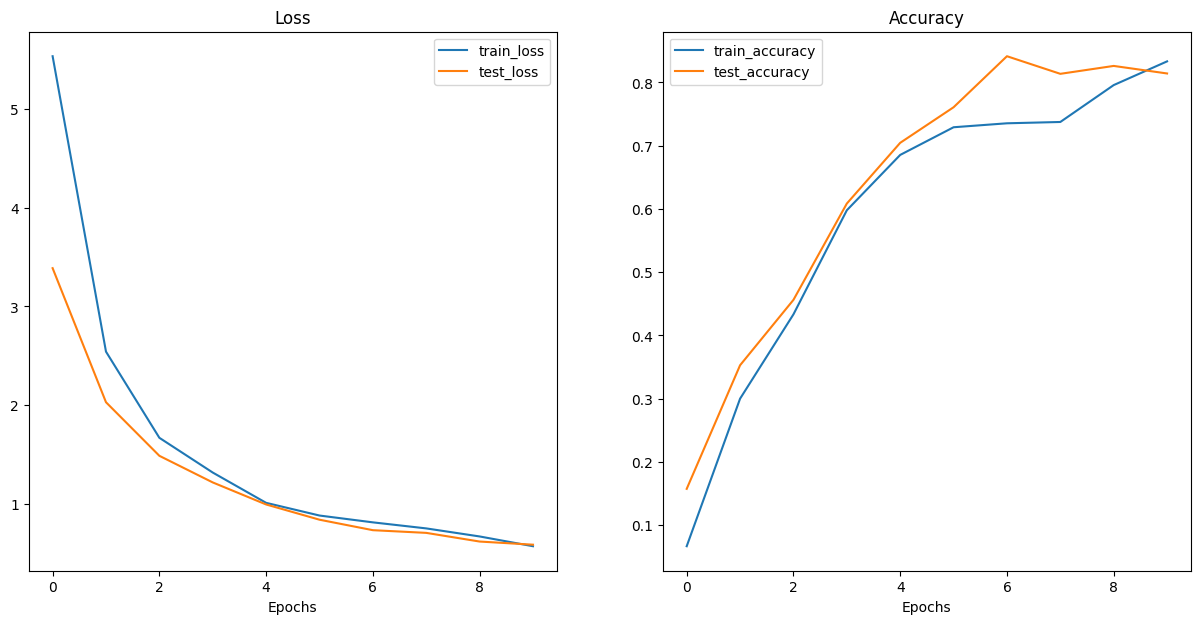

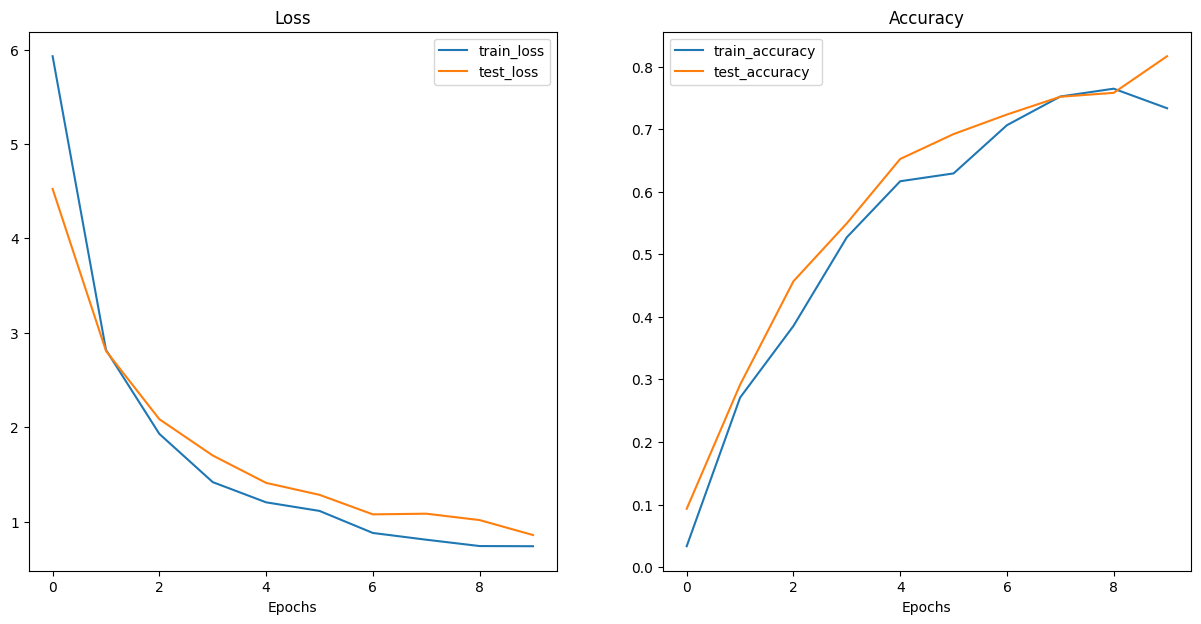

In [89]:
# plot both model to see the different
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py file. Downloading file...")
  with open("helper_functions.py", "wb") as f:
      request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
      print("Downloading helper_functions.py file...")
      f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)
plot_loss_curves(results_1)

In [94]:
display(compare_df)

,train_loss,train_acc,test_loss,test_acc,train_loss,train_acc,test_loss,test_acc
0,5.531786,0.066667,3.387619,0.157386,5.929891,0.033333,4.524273,0.093182
1,2.543179,0.300000,2.031354,0.352841,2.818303,0.270833,2.807820,0.291477
2,1.671542,0.433333,1.489421,0.456250,1.928475,0.385417,2.084116,0.456818
3,1.320143,0.597917,1.220150,0.608523,1.417533,0.527083,1.699710,0.549432
4,1.013595,0.685417,0.997142,0.704545,1.203486,0.616667,1.409570,0.652273
5,0.885246,0.729167,0.843030,0.760795,1.112497,0.629167,1.282868,0.692045
6,0.816218,0.735417,0.736999,0.841477,0.878945,0.706250,1.075948,0.723295
7,0.755003,0.737500,0.709777,0.813636,0.807458,0.752083,1.083103,0.751705
8,0.673581,0.795833,0.622118,0.826136,0.740255,0.764583,1.015394,0.757955
9,0.574766,0.833333,0.590277,0.814205,0.738443,0.733333,0.857065,0.816477
